**A/B TESTING**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [ ]:
url = "https://docs.google.com/spreadsheets/d/1lNKEMrgFF4akPhIS6GyCJ_OaZUsn0VVo/export?format=csv"

In [ ]:
df = pd.read_csv(url)
df.head()

,user_id,group,converted,time_spent(second),order_value_idr
0,1,A,0,"117,5209442",NaN
1,2,B,0,"101,7614061",NaN
2,3,B,1,"98,27599065",Rp 699.364
3,4,B,0,"111,5483958",NaN
4,5,A,0,"105,2558401",NaN


In [ ]:
# Menangani NaN di order_value_idr
df["order_value_idr"] = pd.to_numeric(df["order_value_idr"], errors="coerce").fillna(0).astype("int64")

In [ ]:
# Menangani NaN di time_spend(second)
df["time_spent(second)"] = pd.to_numeric(df["time_spent(second)"].str.replace(',', '.'), errors='coerce')
median_time_spend = df["time_spent(second)"].median()
df["time_spent(second)"] = df["time_spent(second)"].fillna(median_time_spend)

In [ ]:
df.isnull().sum()

,0
user_id,0
group,0
converted,0
time_spent(second),0
order_value_idr,0


3. Explorasi Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             100000 non-null  int64  
 1   group               100000 non-null  object 
 2   converted           100000 non-null  int64  
 3   time_spent(second)  100000 non-null  float64
 4   order_value_idr     100000 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ MB


In [ ]:
df.describe()

,user_id,converted,time_spent(second),order_value_idr
count,100000.000000,100000.00000,100000.000000,100000.0
mean,50000.500000,0.09454,109.848871,0.0
std,28867.657797,0.29258,27.327606,0.0
min,1.000000,0.00000,-12.126419,0.0
25%,25000.750000,0.00000,91.219559,0.0
50%,50000.500000,0.00000,107.953437,0.0
75%,75000.250000,0.00000,126.575044,0.0
max,100000.000000,1.00000,246.580990,0.0


4.Ringkasan Data Berdasarkan Group

In [ ]:
df["time_spent(second)"] = pd.to_numeric(df["time_spent(second)"], errors="coerce")
df["order_value_idr"] = pd.to_numeric(df["order_value_idr"], errors="coerce")
df["converted"] = pd.to_numeric(df["converted"], errors="coerce")

In [ ]:
# Menambahkan kolom untuk bounce rate (bounced = 1 jika tidak mengonversi, 0)
df["bounced"] = 1 - df["converted"]

In [ ]:
summary = df.groupby("group").agg(
    total_users = ("user_id", "count"),
    total_conversion = ("converted", "sum"),
    conversion_rate = ("converted", lambda x: x.mean() * 100),
    total_bounce = ("bounced", "sum"),
    bounce_rate = ("bounced", lambda x: (x.sum() / x.count()) * 100),
    avg_time_spent = ("time_spent(second)", "mean"),
    avg_order_value = ("order_value_idr", "mean")
)
print("Ringkasan Metrik Utama:")
print(summary)

Ringkasan Metrik Utama:
       total_users  total_conversion  conversion_rate  total_bounce  \
group                                                                 
A            49934              3895         7.800296         46039   
B            50066              5559        11.103344         44507   

       bounce_rate  avg_time_spent  avg_order_value  
group                                                
A        92.199704      119.713851              0.0  
B        88.896656      100.009901              0.0  


5. Visualisasi Data

/tmp/ipython-input-32-3667306269.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="group", y="converted", data=df, estimator=np.mean, ci="sd", ax=axes[0])
/tmp/ipython-input-32-3667306269.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="group", y="bounced", data=df, estimator=np.mean, ci="sd", ax=axes[1])


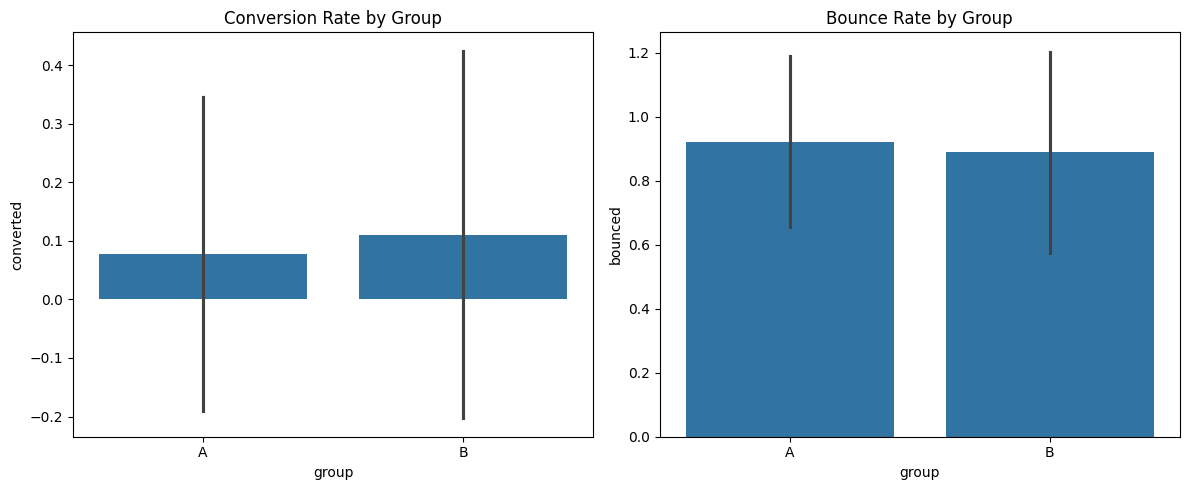

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

## Conversion Rate
sns.barplot(x="group", y="converted", data=df, estimator=np.mean, ci="sd", ax=axes[0])
axes[0].set_title("Conversion Rate by Group")
axes[0].set_label("Conversion Rate")

## Bounce Rate
sns.barplot(x="group", y="bounced", data=df, estimator=np.mean, ci="sd", ax=axes[1])
axes[1].set_title("Bounce Rate by Group")
axes[1].set_label("Bounce Rate")

plt.tight_layout()
plt.show()

6. Uji Hipotesis

a. Persiapan Data

In [ ]:
## Pisahkan data berdasarkan group
group_A = df[df["group"]=="A"]
group_B = df[df["group"]=="B"]



b. Uji Statistik

    Menggunakan z-test untuk tingkat konversi (karena ini adalah data kategori/biner).
    Menggunakan t-test untuk metrik kontinu seperti waktu yang dihabiskan dan nilai pesanan.



In [ ]:
## Z-test untuk tingkat konversi
from statsmodels.stats.proportion import proportions_ztest

success_converted = [group_A["converted"].sum(), group_B["converted"].sum()]
trials_converted = [group_A["converted"].count(), group_B["converted"].count()]
z_stat_conv, p_value_conv = proportions_ztest(success_converted, trials_converted)

## Z-test untuk bounce rate
success_bounced = [group_A["bounced"].sum(), group_B["bounced"].sum()]
trials_bounced = [group_A["bounced"].count(), group_B["bounced"].count()]
z_stat_bounce, p_value_bounce = proportions_ztest(success_bounced, trials_bounced)

## T-test untuk waktu yang dihabiskan
t_stat_time, p_value_time = stats.ttest_ind(group_A["time_spent(second)"], group_B["time_spent(second)"])

## T-test untuk rata-rata nilai pesanan
t_stat_order, p_value_order = stats.ttest_ind(group_A["order_value_idr"], group_B["order_value_idr"])

## Hasil Uji Statistik
print("\nHasil Uji Statistik:")
print(f"Tingkat Konversi - Z-Stat: {z_stat_conv:.2f}, P-Value: {p_value_conv:.4f}")
print(f"Tingkat Bounce Rate - Z-Stat: {z_stat_bounce:.2f}, P-Value : {p_value_bounce:.4f}")
print(f"Waktu di Halaman - T-Stat: {t_stat_time:.2f}, P-Value: {p_value_time:.4f}")
print(f"Rata-rata Nilai Pesanan - T-Stat: {t_stat_order:.2f}, P-Value:{t_stat_order:.4f}")


Hasil Uji Statistik:
Tingkat Konversi - Z-Stat: -17.85, P-Value: 0.0000
Tingkat Bounce Rate - Z-Stat: 17.85, P-Value : 0.0000
Waktu di Halaman - T-Stat: 122.22, P-Value: 0.0000
Rata-rata Nilai Pesanan - T-Stat: nan, P-Value:nan


7. Analisis

1. Tingkat Konversi

    Z-Stat: -17.85, P-Value: 0.0000

    Hasil uji Z menunjukkan perbedaan yang sangat signifikan antara Grup A (kontrol) dan Grup B (variasi). P-Value yang jauh di bawah 0.05 (nilai signifikansi standar) mengindikasikan bahwa perubahan desain halaman checkout dari kontrol ke variasi mempengaruhi tingkat konversi secara signifikan. Hipotesis bahwa desain yang lebih sederhana meningkatkan konversi diterima.
2. Tingkat Bounce Rate

    Z-Stat: 17.85, P-Value: 0.0000

    Hasil ini menunjukkan bahwa perbedaan dalam tingkat bounce rate antara Grup A dan Grup B sangat signifikan. P-Value yang sangat kecil mengindikasikan bahwa desain halaman checkout baru mengurangi tingkat pentalan (bounce rate), yang berarti pengguna lebih cenderung tetap berada di halaman checkout pada versi baru. Ini mendukung hipotesis bahwa desain yang lebih sederhana dan lebih mudah dinavigasi mengurangi kebingungan dan meningkatkan keterlibatan.
3. Waktu di Halaman

    T-Stat: 122.22, P-Value: 0.0000

    Hasil uji T menunjukkan perbedaan signifikan dalam waktu yang dihabiskan di halaman checkout antara Grup A dan Grup B. Dengan P-Value yang sangat kecil, kita dapat menyimpulkan bahwa desain baru mempengaruhi waktu interaksi pengguna, meskipun lebih banyak waktu dihabiskan di halaman checkout, ini bisa menjadi indikator bahwa pengguna merasa lebih nyaman dan lebih cenderung menyelesaikan pembelian.
4. Rata-rata Nilai Pesanan

    T-Stat: nan, P-Value: nan

    Nilai NaN pada hasil uji ini mengindikasikan adanya masalah dalam data, mungkin karena nilai NaN atau distribusi yang tidak memadai dalam salah satu grup. Oleh karena itu, tidak ada kesimpulan yang dapat ditarik mengenai perbedaan rata-rata nilai pesanan antara grup kontrol dan variasi. Pengisian atau pengecekan lebih lanjut terhadap data perlu dilakukan.



8. Kesimpulan

    Desain checkout yang disederhanakan (Versi B) signifikan meningkatkan tingkat konversi dan mengurangi bounce rate.
    Waktu di halaman checkout juga meningkat, menunjukkan bahwa pengguna mungkin lebih terlibat dengan proses checkout.
    Masalah dengan nilai pesanan perlu diperbaiki atau diperiksa lebih lanjut, karena data menunjukkan hasil yang tidak konsisten.
    Secara keseluruhan, perubahan desain halaman checkout memberikan dampak positif terhadap metrik utama dan sekunder, mendukung hipotesis awal untuk meningkatkan pengalaman pengguna dan tingkat konversi.

